In [1]:
%matplotlib inline
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm_notebook as tqdm
import time

import scipy.signal

root = './input_data/DIP_2019_A3/'

In [2]:
def read_img(name, gray=False):
    fg = cv2.imread(name)
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    if gray: fg = cv2.cvtColor(fg, cv2.COLOR_RGB2GRAY)
    return fg

def plot(imgs, gray=False, titles=[], FigSize=(20,8), vmap=None, layout=None):
    fig = plt.figure(figsize=FigSize)
    
    num_plots = layout
    if layout==None:
        if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
        else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))

    vflag = True
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not (vmap!=None and vflag):
            vflag=False
            vmap={}
            vmap['vmin']=np.min(imgs[i])
            vmap['vmax']=np.max(imgs[i])
        
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', **vmap)
            
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


In [3]:
def multilayer(func, img, *args, **kwargs):
    fimg = []
    for i in range(3):
        fimg.append(func(img[:,:,i], *args, **kwargs))
    
    return np.uint8(np.dstack(fimg))

def im2col(img, windowSize, stride=1):
    n,m = img.shape
    x,y = windowSize
    
    rowc = n-x+1
    colc = m-y+1
    
    st = np.arange(rowc)[::stride, np.newaxis]*m + np.arange(colc)[::stride] 
    en = np.arange(x)[:,np.newaxis]*m + np.arange(y) 
    
    return img.ravel()[en.ravel()[:, np.newaxis] + st.ravel()]
    
    
def conv2D(img, fil, stride=1, size='same', padding='edge'):
    
        
    img = np.float64(img) 
    fil = np.float64(fil)    
    
    n,m = img.shape
    x,y = fil.shape
    
    if size=='same':
        pv = n*(stride-1)-1+x
        ph = m*(stride-1)-1+y
        
        img = np.pad(img, ((pv//2, pv-pv//2), (ph//2, ph-ph//2)), padding)
        n,m = img.shape
        
    rowc = n-x+1
    colc = m-y+1
    
    img_vec = im2col(img, fil.shape, stride)
    fil_vec = fil.ravel()[:, np.newaxis]
    
    fimg_vec = fil_vec.T @ img_vec
    
    return fimg_vec.reshape((rowc, colc))

---
<div width="100%" align="center"> <h1>Q1</h1></div>

---

## 1. 1D FFT

In [4]:
def fft(x):
    if x.shape[0]==1:
        return x
    
    N = x.shape[0]
    X = np.zeros((N,1))
    
    E = fft(x[0:N:2, :])
    O = fft(x[1:N:2, :])
    w = np.exp(-2*np.pi*np.arange(0,N//2)*1j/N)[:,None]
    
    return np.vstack( (E+w*O, E-w*O) )


In [5]:
np.abs(fft(np.random.uniform(size=(4,2))))

array([[1.22985662, 1.61618721],
       [0.70519907, 0.95610746],
       [0.80202427, 0.24086202],
       [0.70519907, 0.95610746]])

## 2. 2D FFT

In [6]:
img = read_img(root+'rectangle.jpg', gray=True)

In [7]:
def fft2D(img, Plot=True):
    img = np.array(img, np.float64)
    fimg = fft(fft(img).T).T
    
    if Plot:
        plot([img], FigSize=(5,5), gray=True)
        plot([np.fft.fftshift(np.log(np.abs(fimg)+1))], FigSize=(5,5))
    

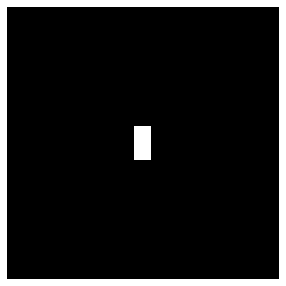

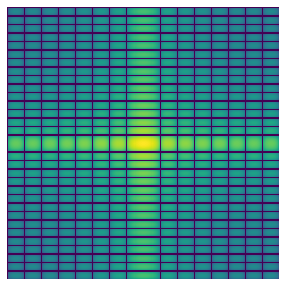

In [8]:
fft2D(img)

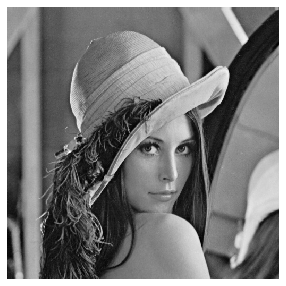

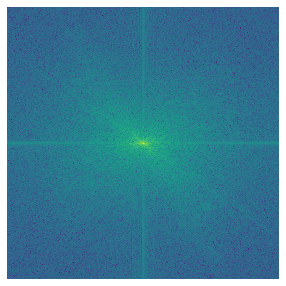

In [9]:
img = read_img(root+'lena.jpg', gray=True)
fft2D(img)

---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

## 1.

In [10]:
img = read_img(root+'lena.jpg', gray=True)

In [11]:
def idealLowPass(img, D0):
    img = np.array(img, np.float64)
    fft = np.fft.fftshift(np.fft.fft2(img))
    
    n,m = img.shape
    
    x = np.arange(-(n//2), n-n//2)
    y = np.arange(-(m//2), m-m//2)
    
    x,y = np.meshgrid(y,x)
    f = (np.sqrt(x**2 + y**2)<D0)
    
    fft1 = fft * f
    fimg = np.fft.ifft2(np.fft.fftshift(fft1))
    plot([f, np.log(np.abs(fft1)+1), np.log(1+np.abs(fft)), np.abs(fimg)], \
         gray=True, layout=(2,2), FigSize=(10,10))
    

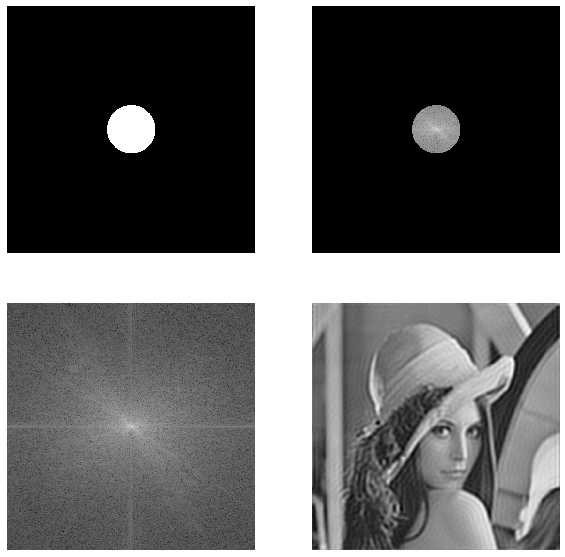

In [12]:
idealLowPass(img, 50)

In [13]:
def butterworthLowPass(img, D0, N, Plot=True):
    img = np.array(img, np.float64)
    fft = np.fft.fftshift(np.fft.fft2(img))
    
    n,m = img.shape
    
    x = np.arange(-(n//2), n-n//2)
    y = np.arange(-(m//2), m-m//2)
    
    x,y = np.meshgrid(y,x)
    d = (np.sqrt(x**2 + y**2))
    
    f = 1/(1+(d/D0)**(2*N))
    
    fft1 = fft * f
    fimg = np.fft.ifft2(np.fft.fftshift(fft1))
    if Plot:
        plot([f, np.log(np.abs(fft1)+1), np.log(1+np.abs(fft)), np.abs(fimg)], \
             gray=True, layout=(2,2), FigSize=(10,10))
    
    return np.abs(fimg)

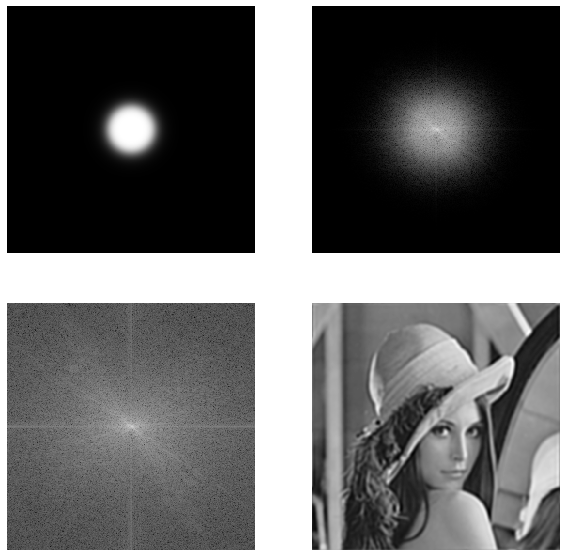

In [14]:
a = butterworthLowPass(img, 50, 4)

In [15]:
def gaussianLowPass(img, D0, Plot=True):
    img = np.array(img, np.float64)
    fft = np.fft.fftshift(np.fft.fft2(img))
    
    n,m = img.shape
    
    x = np.arange(-(n//2), n-(n//2))
    y = np.arange(-(m//2), m-(m//2))

    x,y = np.meshgrid(y,x)
    d = (np.sqrt(x**2 + y**2))

    f = np.exp(-((d/D0)**2)/2)
    
    fft1 = fft * f
    fimg = np.fft.ifft2(np.fft.fftshift(fft1))
    if Plot:
        plot([f, np.log(np.abs(fft1)+1), np.log(1+np.abs(fft)), np.abs(fimg)], \
             gray=True, layout=(2,2), FigSize=(10,10))
    
    return np.abs(fimg)

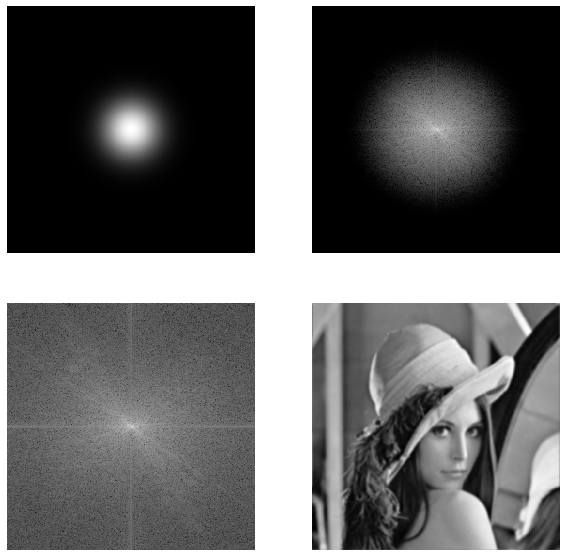

In [16]:
a = gaussianLowPass(img, 40)

## 2.

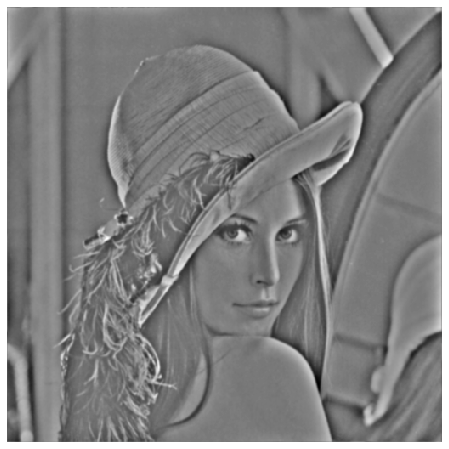

In [17]:
fimg = (gaussianLowPass(img, 98, Plot=False) - gaussianLowPass(img,9, Plot=False))
plot([fimg], gray=True)

>The effect is that of a band pass filter. The gaussian with the bigger D0 allows more frequencies throught than the one with the lower D0, hence their subtraction acts as a band pass filter.

---
<div width="100%" align="center"> <h1>Q3</h1></div>

---

![](./input_data/hw_ans/dip_3_3.jpg)

---
<div width="100%" align="center"> <h1>Q4</h1></div>

---

>The noise in the image is highe frequency strips in verticle and horizontal direction. So to remove those, i first remove the high frequencies in the horizontal and verticle direction using 2 notch filters. To remove further high frequncy noise which wasn''t in these 2 directions I use a butterworth filter.

In [18]:
img = read_img(root+'land.png', gray=True)

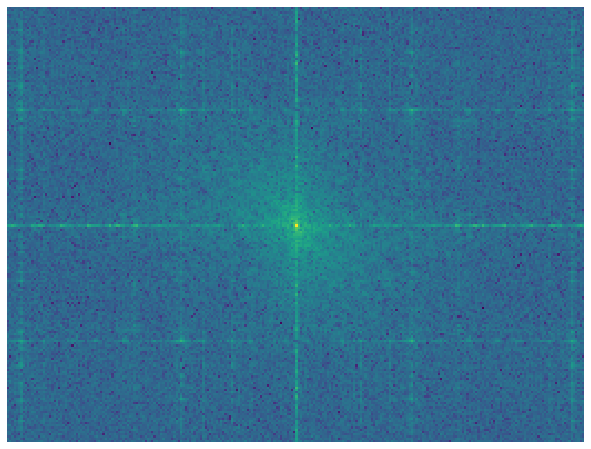

In [19]:
fft = np.fft.fftshift(np.fft.fft2(img))
plot([np.log(1+np.abs(fft))])

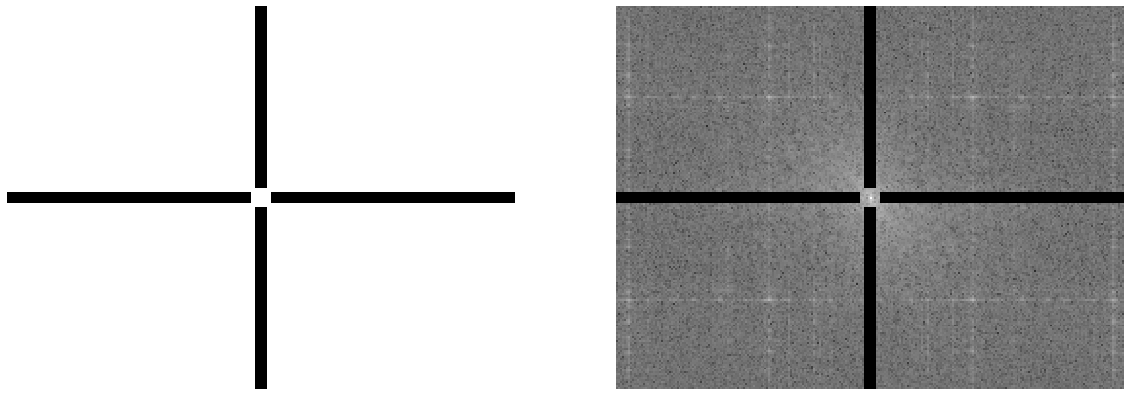

In [20]:
f = np.ones(img.shape)
notch = 5
thickness = 3
f[notch:-notch,:thickness] = 0
f[notch:-notch,-thickness:] = 0
f[:thickness,notch:-notch] = 0
f[-thickness:,notch:-notch] = 0

f = np.fft.fftshift(f)
plot([f, np.log(1+np.abs(fft*f))], gray=True)

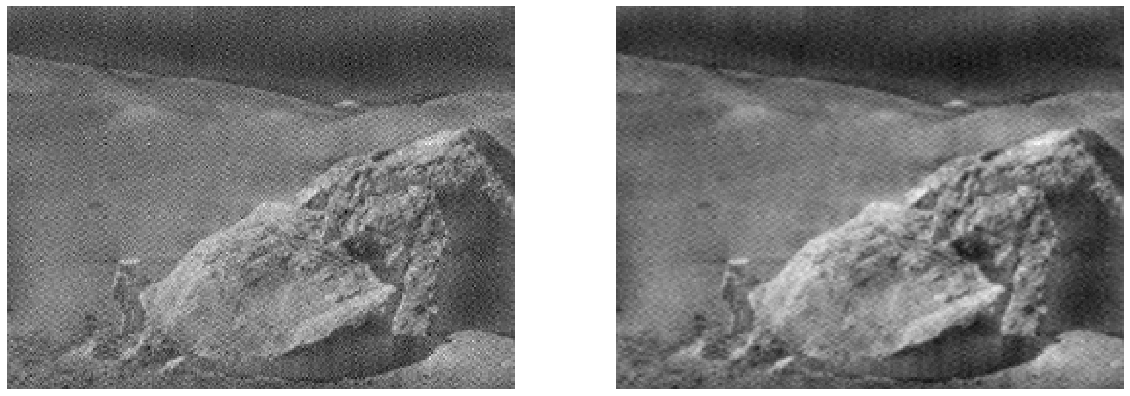

In [21]:
notch_filtered = np.abs(np.fft.ifft2(np.fft.fftshift(fft*f)))
b = notch_filtered
b = butterworthLowPass(notch_filtered, 70, 1, Plot=False)
plot([notch_filtered, b], gray=True, FigSize=(20,20))


---
<div width="100%" align="center"> <h1>Q5</h1></div>

---

In [22]:
img = read_img(root+'lena.jpg', gray=True)

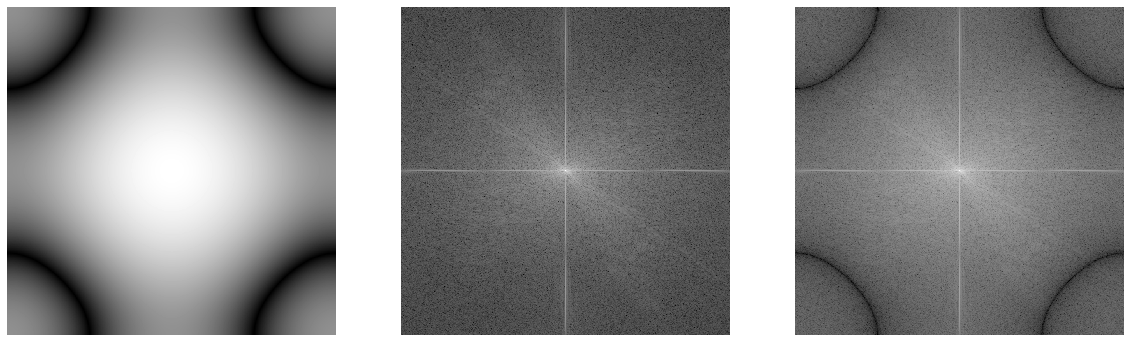

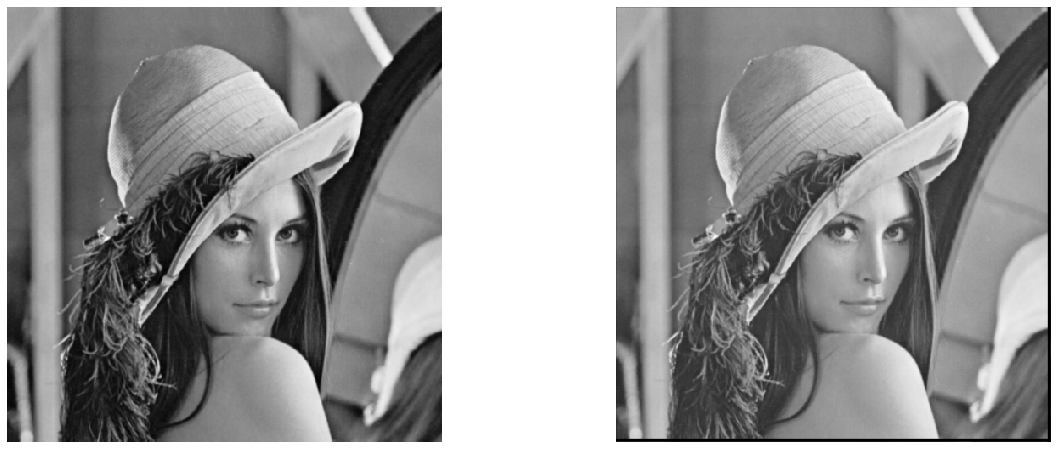

In [23]:
h = np.array([[0,1,0], [1,2,1], [0,1,0]])
timg = conv2D(img,h)

img = np.pad(img, ((2,2),(2,2)), 'constant', constant_values=((0,0),(0,0)))
h = np.pad(h, ((img.shape[0]-3,0),(img.shape[1]-3,0)), 'constant', constant_values=((0,0),(0,0)))

H = np.fft.fftshift(np.fft.fft2(h))
F = np.fft.fftshift(np.fft.fft2(img))

FH = F*H
plot([np.log(1+np.abs(H)), np.log(1+np.abs(F)), np.log(1+np.abs(FH))], gray=True)

plot([timg, np.abs(np.fft.ifft2(FH))], gray=True)
# plot([], gray=True)

![](./input_data/hw_ans/dip_3_5.jpg)

---
<div width="100%" align="center"> <h1>Q6</h1></div>

---

## 1.

In [24]:
f = read_img(root+'land.png', gray=True)
h = read_img(root+'lena.jpg', gray=True)


Error:  4.81082322411656e-08


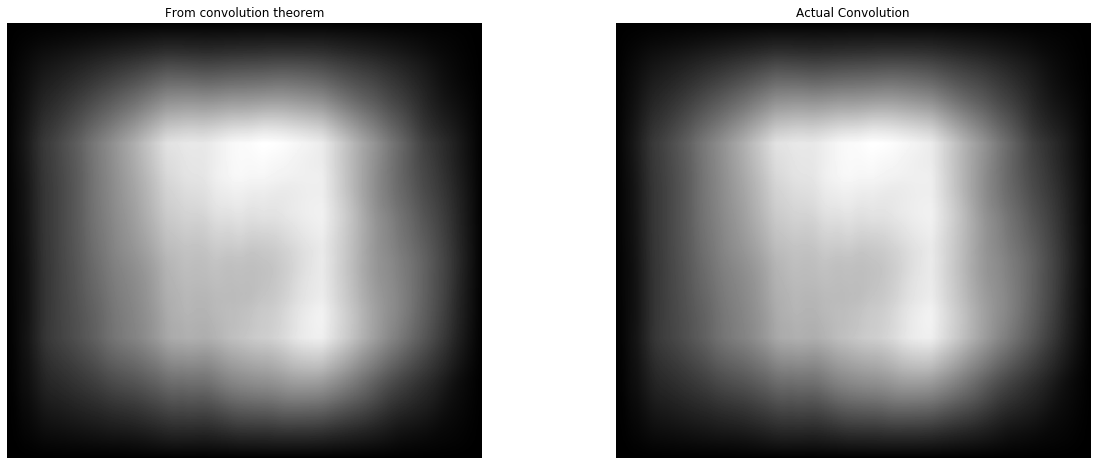

In [25]:
f = np.array(f, np.float64)
h = np.array(h, np.float64)
 
fh = scipy.signal.convolve2d(h,f)

nf, mf = f.shape
nh, mh = h.shape

h = np.pad(h, ((0, f.shape[0]-1),(0, f.shape[1]-1)), 'constant', constant_values=((0,0),(0,0)))
f = np.pad(f, ((0, max(h.shape[0]-f.shape[0],0)),(0,max(h.shape[1]-f.shape[1],0))), 'constant', constant_values=((0,0),(0,0)))

F = np.fft.fft2(f)
H = np.fft.fft2(h)
FH = F*H

fh2 = np.abs(np.fft.ifft2(FH))

plot([fh2,fh], titles=["From convolution theorem", "Actual Convolution"], gray=True) 

print("Error: ",np.sum((fh-fh2)**2))

## 2.

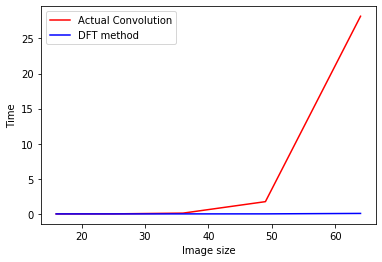

In [26]:
ctime = []
ftime = []
for i in tqdm(range(4, 9)):
    n = 2**i
    f = np.random.uniform(size=(n,n))
    h = np.random.uniform(size=(n,n))    
    
    st = time.time()
    fh = scipy.signal.convolve2d(h,f)
    en = time.time()
    
    ctime.append(en-st)
    
    st = time.time()
    h = np.pad(h, ((0, f.shape[0]-1),(0, f.shape[1]-1)), 'constant', constant_values=((0,0),(0,0)))
    f = np.pad(f, ((0, max(h.shape[0]-f.shape[0],0)),(0,max(h.shape[1]-f.shape[1],0))), 'constant', constant_values=((0,0),(0,0)))

    F = np.fft.fft2(f)
    H = np.fft.fft2(h)
    FH = F*H

    fh2 = np.abs(np.fft.ifft2(FH))
    en = time.time()
    
    ftime.append(en-st)
    
    assert(np.allclose(fh,fh2))
    
plt.plot(np.array([i**2 for i in range(4,9)]), np.array(ctime), 'r', label="Actual Convolution")
plt.plot(np.array([i**2 for i in range(4,9)]), np.array(ftime), 'b', label="DFT method")
plt.xlabel("Image size")
plt.ylabel("Time")
plt.legend()
plt.show()

---
<div width="100%" align="center"> <h1>Q7</h1></div>

---

## 1.

In [27]:
img = read_img(root+'bricks.jpg', gray=True)

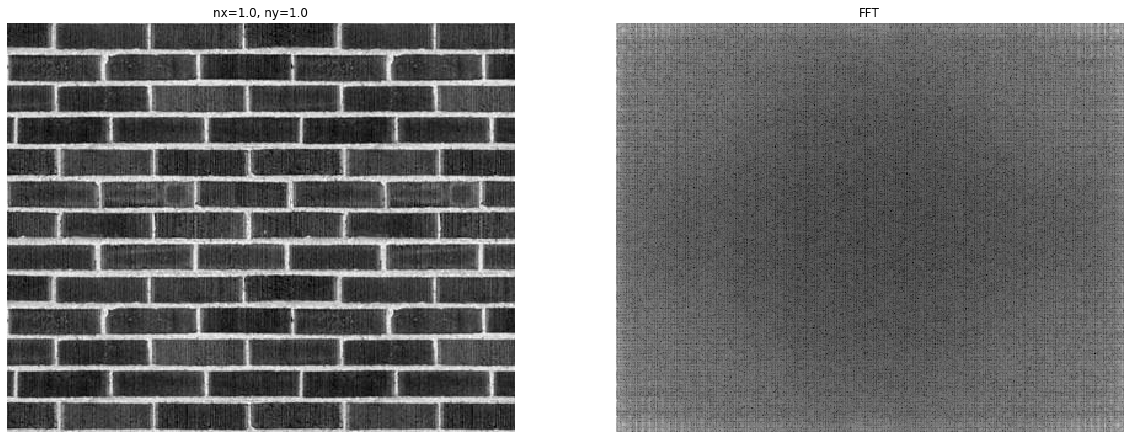

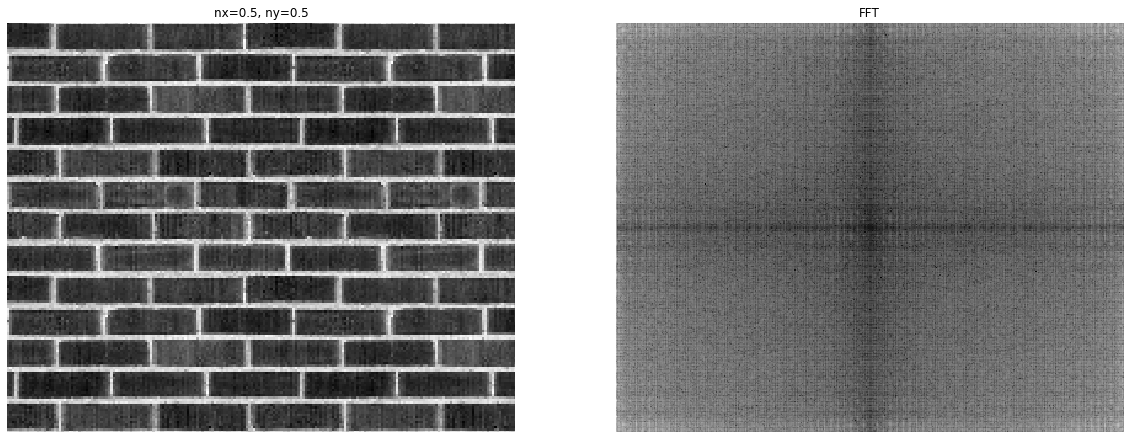

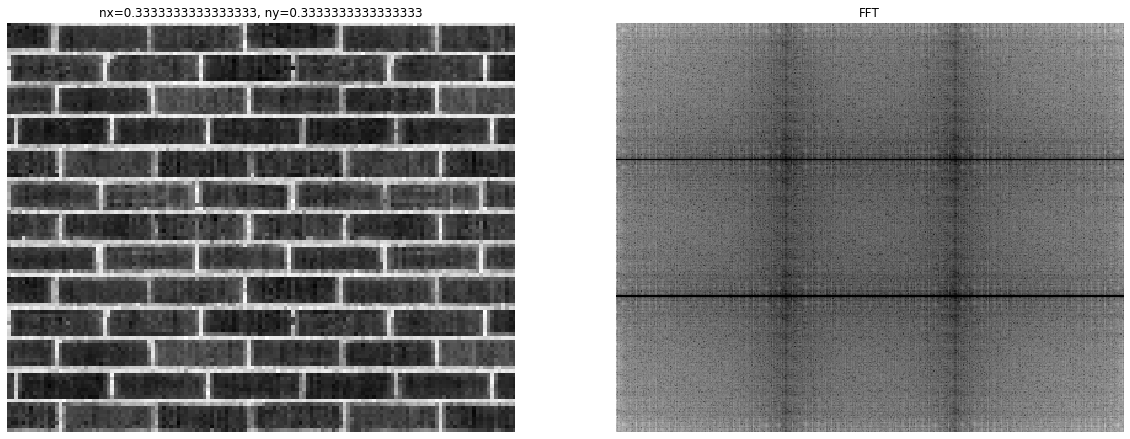

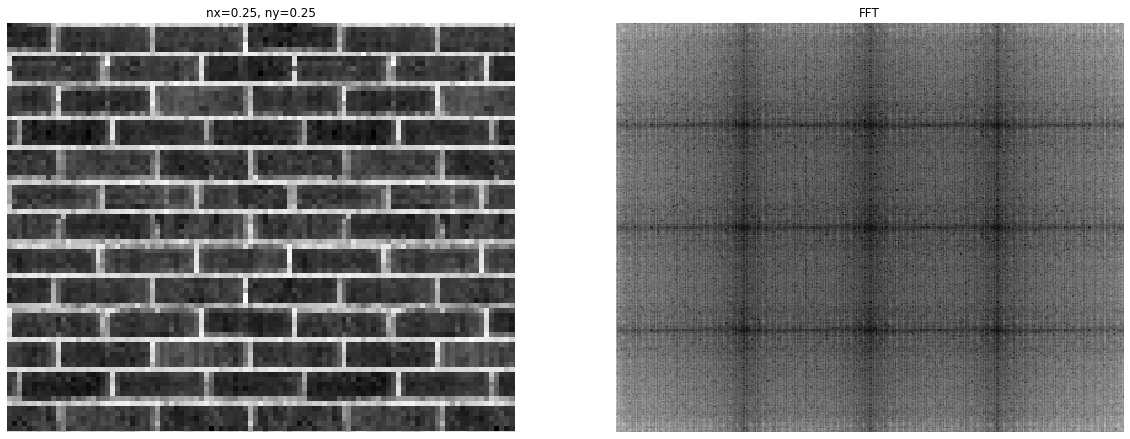

In [28]:
nlist = [(i,i) for i in range(1,5)]
for i in nlist:
    nx = i[0]
    ny = i[1]

    xidxs = np.array([i//nx*nx for i in range(img.shape[0])])
    yidxs = np.array([i//ny*ny for i in range(img.shape[1])])
    fimg = img[xidxs, :]
    fimg = fimg[:, yidxs]
    
    fft = np.log2(1+np.abs(np.fft.fft2(fimg)))
    
    plot([fimg, fft], titles=["nx={}, ny={}".format(1/nx,1/ny), "FFT"], gray=True, layout=(1,2))

>The nyquist frequency is nx=0.5, ny=0.5, since there are very visible aliasing artefacts after that.

## 2.

In [29]:
bimg = gaussianLowPass(img, 20, Plot=False)

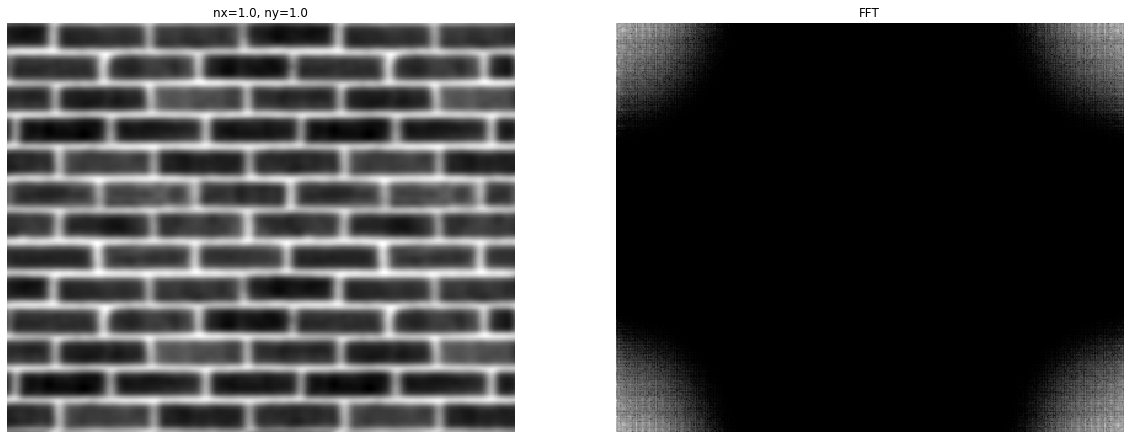

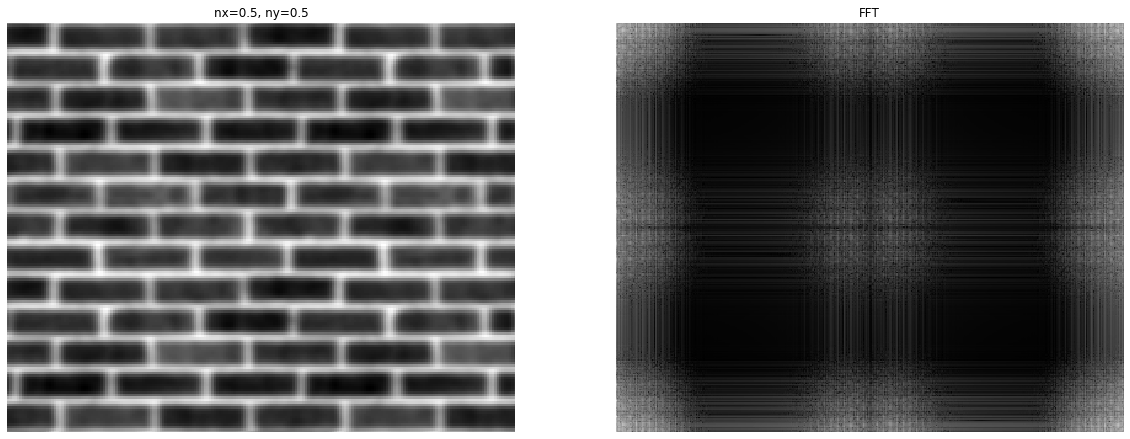

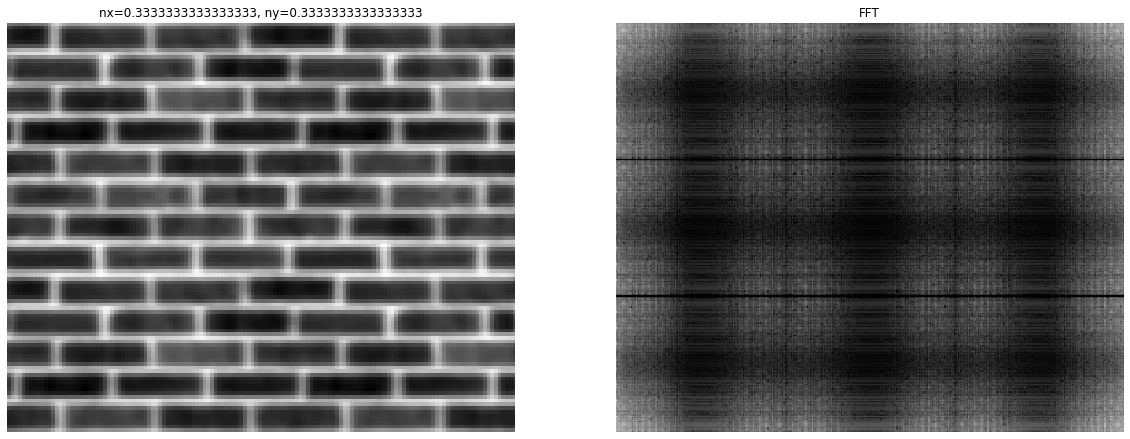

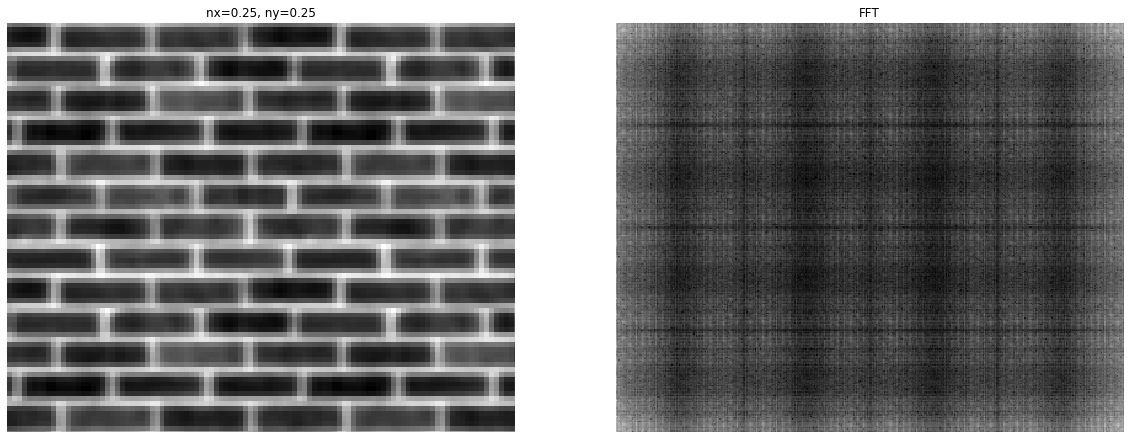

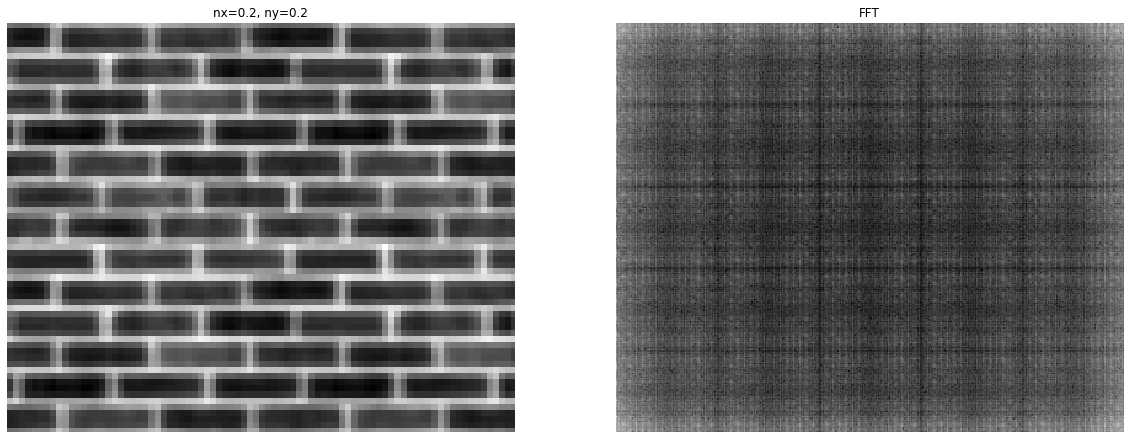

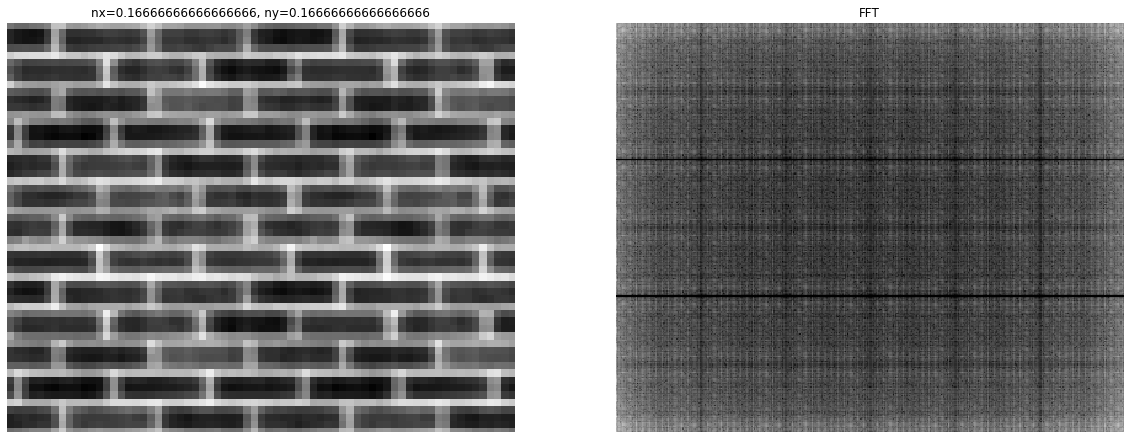

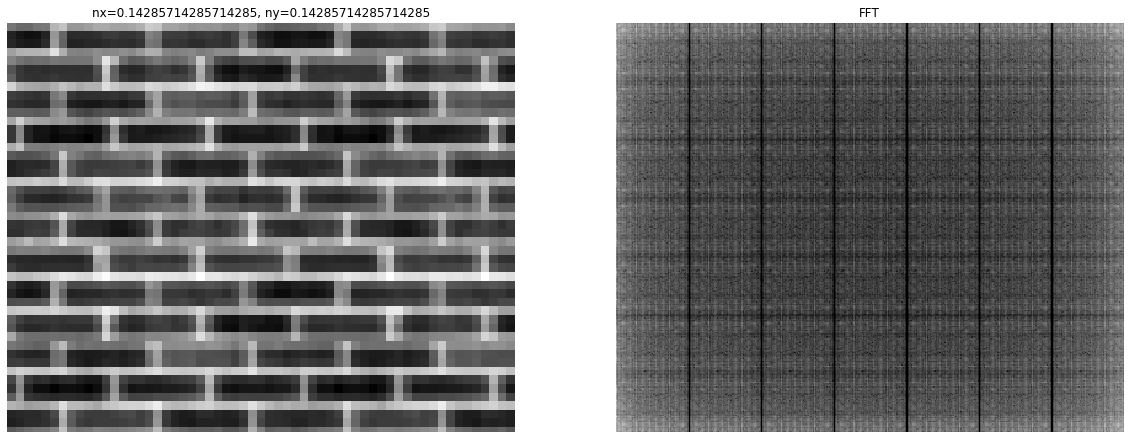

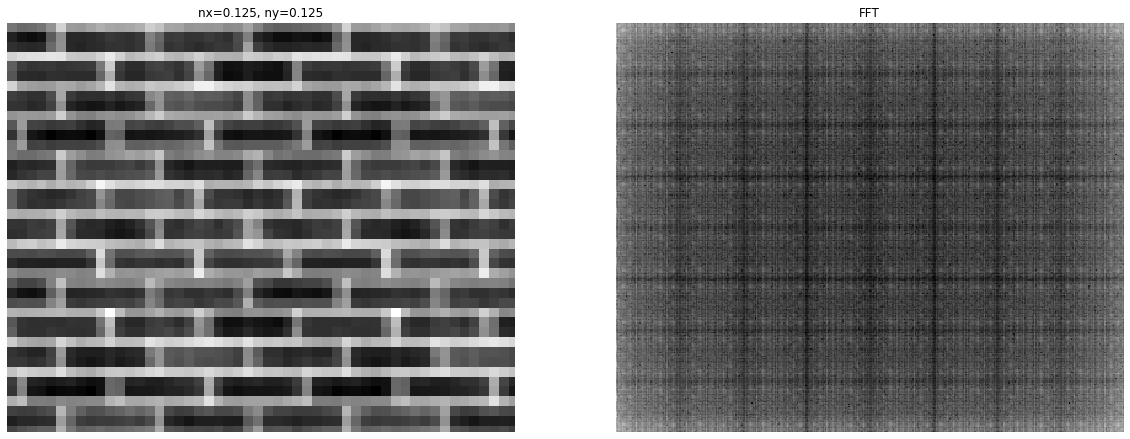

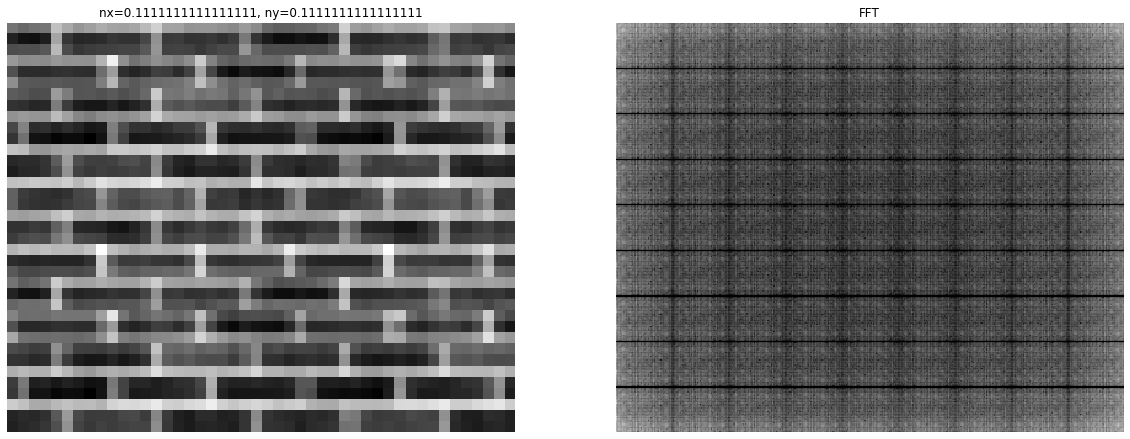

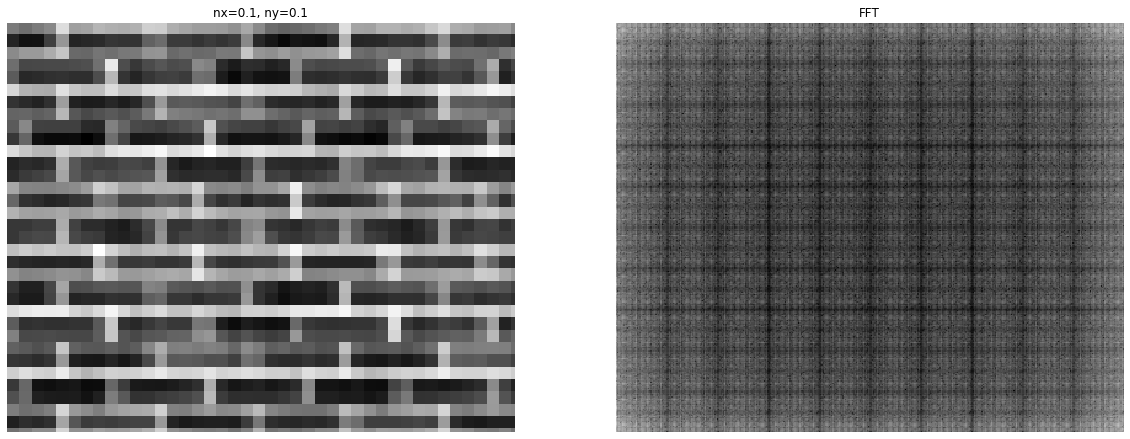

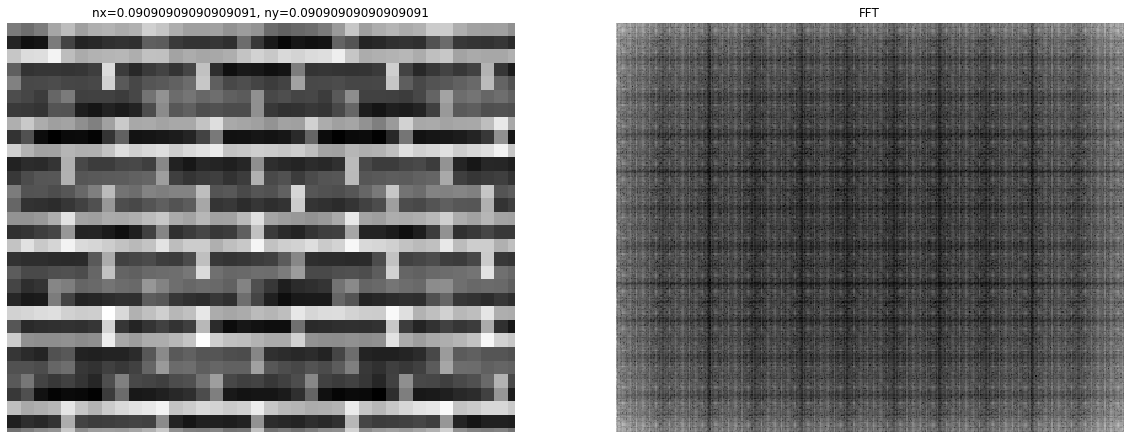

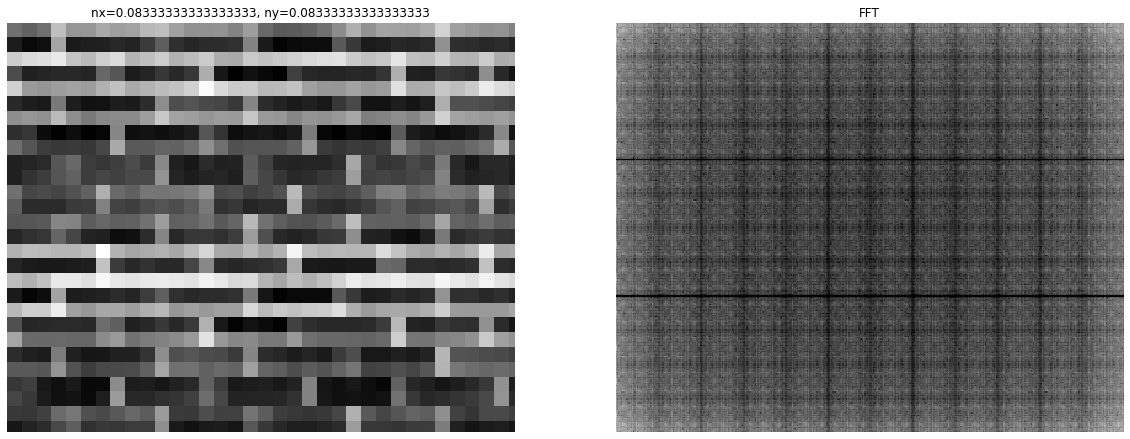

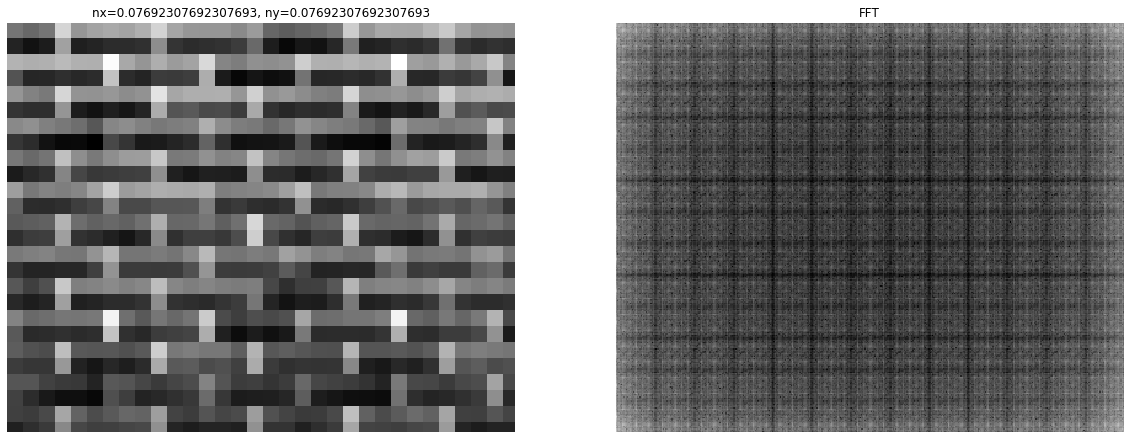

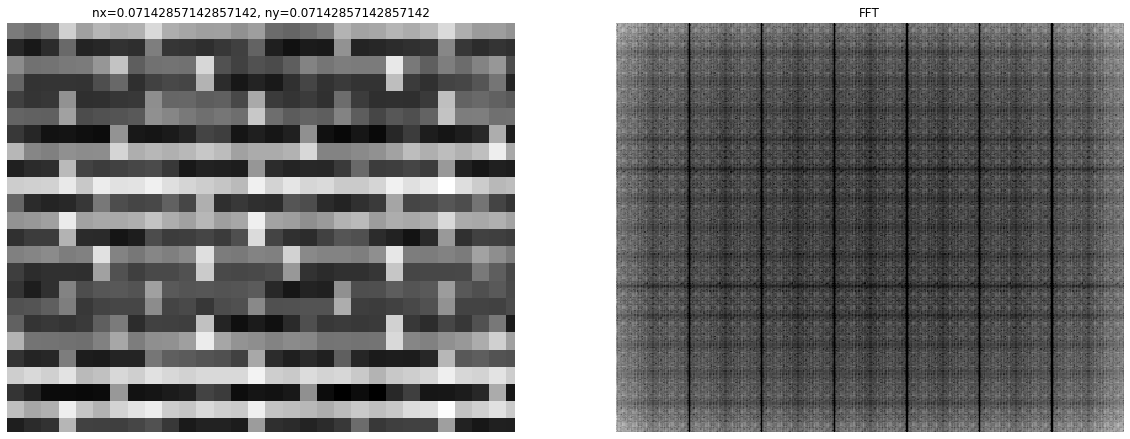

In [30]:
nlist = [(i,i) for i in range(1,15)]
for i in nlist:
    nx = i[0]
    ny = i[1]

    xidxs = np.array([i//nx*nx for i in range(img.shape[0])])
    yidxs = np.array([i//ny*ny for i in range(img.shape[1])])
    fimg = bimg[xidxs, :]
    fimg = fimg[:, yidxs]
    
    fft = np.log2(1+np.abs(np.fft.fft2(fimg)))
    
    plot([fimg, fft], titles=["nx={}, ny={}".format(1/nx,1/ny), "FFT"], gray=True, layout=(1,2))

>As can be seen, after applying a low pass gaussian blur, the $\nu_{max}$ decreases, hence, the nyquist frequency can decrease. We can observe this since nx = 0.25, ny=0.25 is the nyquist frequency of the blurred image

---
<div width="100%" align="center"> <h1>Q8</h1></div>

---

In [31]:
img = read_img(root+"rectangle.jpg", gray=True)

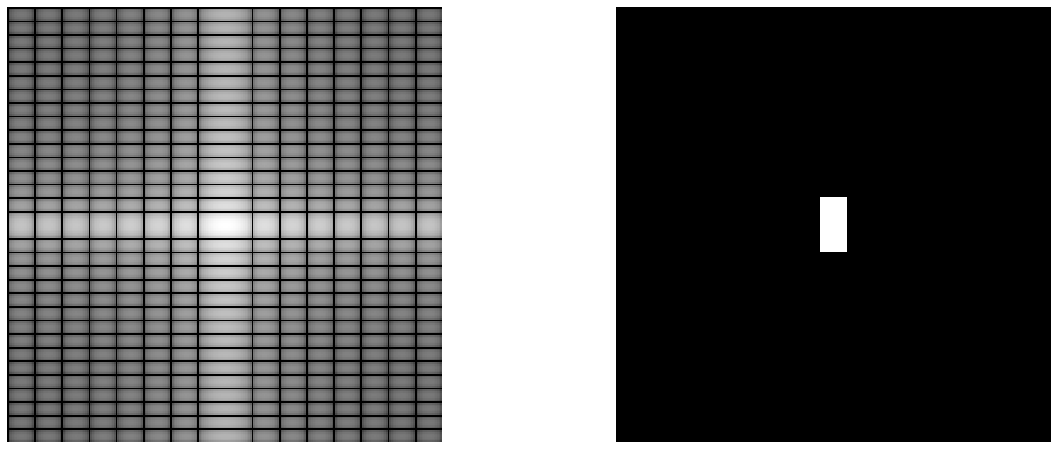

In [32]:
fft = np.fft.fftshift(np.fft.fft2(img))
p_fft = np.log(1+np.abs(fft))
plot([p_fft, img], gray=True)

## 1.

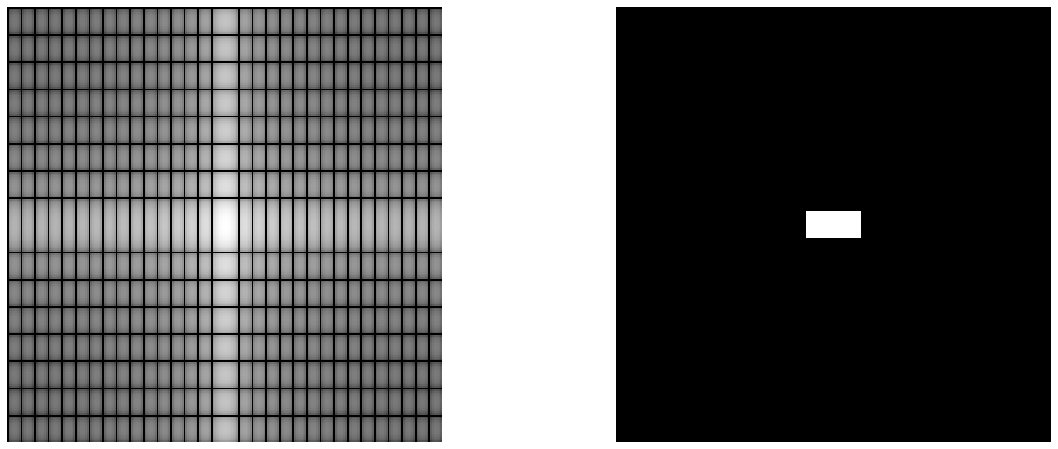

In [33]:
rimg = img.T
fft = np.fft.fftshift(np.fft.fft2(rimg))
p_fft = np.log(1+np.abs(fft))
plot([p_fft, rimg], gray=True)

![](./input_data/hw_ans/dip_3_8_1.jpg)

## 2.

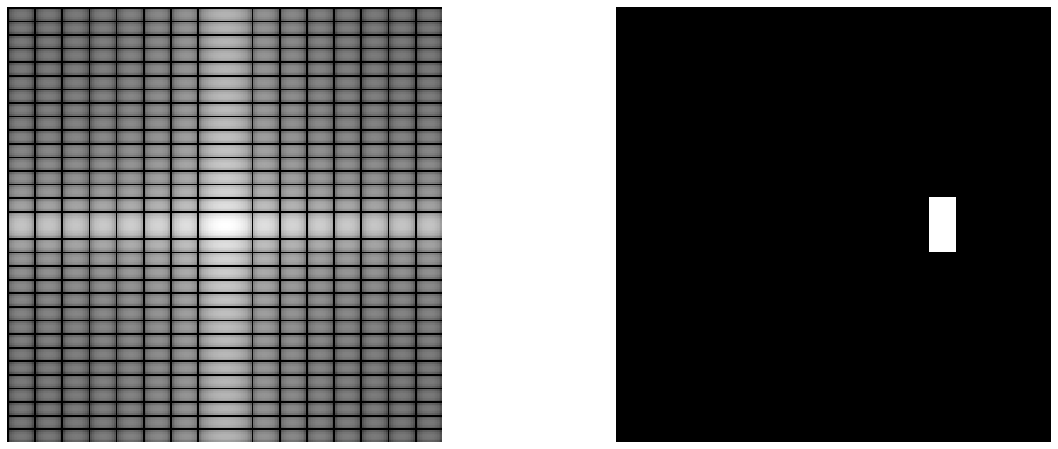

In [34]:
timg = np.zeros(img.shape)
timg[:,-3*img.shape[1]//4:] = img[:,:3*img.shape[1]//4]
fft = np.fft.fftshift(np.fft.fft2(timg))
p_fft = np.log(1+np.abs(fft))
plot([p_fft, timg], gray=True)

![](./input_data/hw_ans/dip_3_8_2.jpg)